In [ ]:

DB_ULR = "neo4j://localhost:7687"
DB_USER = "neo4j"
DB_PASS = "test1234"
DB_NAME = "symptom"

: 

# Create driver
Also set the DB_NAME

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px 
from neo4j import GraphDatabase # Python database driver
from graphdatascience import GraphDataScience # Python GDS client

# And some cermony to create the driver and gds objects
driver = GraphDatabase.driver(DB_ULR, auth=(DB_USER, DB_PASS))
gds = GraphDataScience(DB_ULR, auth=(DB_USER, DB_PASS))
gds.set_database(DB_NAME)

# Create databse and schema

In [3]:
# Create (or replace) database
with driver.session(database = "system") as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            "CREATE OR REPLACE DATABASE {dbname}".format(dbname = DB_NAME)
        ).data()
    )

In [4]:
# Create indexes and constraints
with driver.session(database = DB_NAME) as session:
    session.write_transaction( lambda tx: 
        tx.run(
            "CREATE CONSTRAINT IF NOT EXISTS FOR (n:Symptom) REQUIRE (n.name) IS NODE KEY"
        ).consume()
    )
    session.write_transaction( lambda tx: 
        tx.run(
            "CREATE CONSTRAINT IF NOT EXISTS FOR (n:Disease) REQUIRE (n.name) IS NODE KEY"
        ).consume()     
    )

In [5]:
df = pd.DataFrame( 
    gds.run_cypher('match (n) return count(*) as nodeCount') 
)
df.head()

,nodeCount
0,0


#  Load data

In [6]:
# Read csv file
# Source https://github.com/deshanadesai/Symptom-X-/blob/master/dataset_clean1.csv
csv = pd.read_csv('https://raw.githubusercontent.com/deshanadesai/Symptom-X-/master/dataset_clean1.csv')
csv.head()

,Source,Target,Weight
0,influenza,uncoordination,68
1,influenza,fever,68
2,influenza,pleuritic pain,68
3,influenza,snuffle,68
4,influenza,throat sore,68


In [7]:
# Select all unique symptoms
symptoms = csv['Target'].drop_duplicates().dropna()
symptoms.head()

0    uncoordination
1             fever
2    pleuritic pain
3           snuffle
4       throat sore
Name: Target, dtype: object

In [8]:
# Create Symptom nodes
for chunk in np.array_split(symptoms, 2):
    with driver.session(database = DB_NAME) as session:
        result = session.write_transaction( lambda tx: 
            tx.run(
                """
                UNWIND $symptoms as symptomName
                MERGE (:Symptom{name: symptomName})
                RETURN count(*) as nodesCreated
                """,
                symptoms = chunk.to_list()
            ).data()
        )
        df = pd.DataFrame(result)
df.head()

,nodesCreated
0,202


In [9]:
# Select all unique diseases
diseases = csv['Source'].drop_duplicates().dropna()
diseases.head()

0                influenza
21               gastritis
33    hypercholesterolemia
48                epilepsy
61     insufficiency renal
Name: Source, dtype: object

In [10]:
# Create Disease nodes
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            UNWIND $diseases as diseaseName
            MERGE (:Disease{name: diseaseName})
            RETURN count(*) as nodesCreated
            """,
            diseases = diseases.to_list()
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,nodesCreated
0,148


In [11]:
# Select all SYMPTOM_OV relationships
symptom_of_rels = csv[['Source','Target', 'Weight']]
df.head()

,nodesCreated
0,148


In [12]:
# Create VIEWED relationships
for chunk in np.array_split(symptom_of_rels, 2):
    with driver.session(database = DB_NAME) as session:
        result = session.write_transaction( lambda tx: 
            tx.run(
                """
                UNWIND $data as rel
                MATCH (d:Disease{name: rel.Source}), (s:Symptom{name: rel.Target})
                MERGE (s)-[:SYMPTOM_OF{weight:toInteger(rel.Weight)}]->(d)
                RETURN count(*) as relsCreated
                """,
                data = chunk.to_dict('records')
            ).data()
        )
        df = pd.DataFrame(result)
df.head()

,relsCreated
0,1062


# Some basic queries

In [13]:
# Syptom with highest degree
# Question: What does does it mean?
df = gds.run_cypher(
    """
    MATCH (s:Symptom)-[r:SYMPTOM_OF]->(d:Disease)
    RETURN 
        s.name as symptom, 
        collect(d.name) as diseases, 
        count(d) as number_of_diseases
    ORDER BY number_of_diseases DESC LIMIT $limit
    """,
    params = {"limit": 5}
)
df.head()

,symptom,diseases,number_of_diseases
0,shortness of breath,"[adhesion, anemia, arthritis, asthma, bronchit...",49
1,pain,"[adenocarcinoma, adhesion, anemia, anxiety sta...",44
2,fever,"[Alzheimer's disease, HIV, acquired immuno-def...",38
3,diarrhea,"[HIV, Pneumocystis carinii pneumonia, acquired...",30
4,pain abdominal,"[adenocarcinoma, biliary calculus, carcinoma c...",29


In [14]:
# Syptom with lowest degree
# Question: What does does it mean?
df = gds.run_cypher(
    """
    MATCH (s:Symptom)-[r:SYMPTOM_OF]->(d:Disease)
    RETURN 
        s.name as symptom, 
        collect(d.name) as diseases, 
        count(d) as number_of_diseases
    ORDER BY number_of_diseases ASC LIMIT 3
    """
)
df.head()

,symptom,diseases,number_of_diseases
0,tremor resting,[Alzheimer's disease],1
1,pin-point pupils,[Alzheimer's disease],1
2,drool,[Alzheimer's disease],1


In [15]:
# Possible diseases given two symptoms
df = gds.run_cypher(
    """
    MATCH (s1:Symptom{name:"fever"})-[:SYMPTOM_OF]->(d:Disease)<-[:SYMPTOM_OF]-(s2:Symptom{name:"swelling"})
    RETURN d.name as disease
    """
)
df.head()

,disease
0,osteomyelitis
1,exanthema
2,cellulitis
3,infection
4,lymphatic diseases


In [16]:
# Possible diseases given two symptoms
# Weighted
df = gds.run_cypher(
    """
    MATCH (s1:Symptom{name:"fever"})-[r1:SYMPTOM_OF]->(d:Disease)<-[r2:SYMPTOM_OF]-(s2:Symptom{name:"swelling"})
    RETURN d.name as disease, 
            r1.weight + r2.weight as weight 
    ORDER BY weight DESC 
    """
)
df.head()

,disease,weight
0,infection,1260
1,cellulitis,682
2,chronic kidney failure,560
3,exanthema,416
4,lymphatic diseases,320


# Graph data science
Can we arrange syptoms based on diseases they share?

In [17]:
G1, project_stats = gds.graph.project('p1',['Disease', 'Symptom'], ['SYMPTOM_OF'])
project_stats

nodeProjection            {'Disease': {'label': 'Disease', 'properties':...
relationshipProjection    {'SYMPTOM_OF': {'orientation': 'NATURAL', 'agg...
graphName                                                                p1
nodeCount                                                               552
relationshipCount                                                      2110
projectMillis                                                           597
Name: 0, dtype: object

In [18]:
gds.nodeSimilarity.stats(G1, 
    similarityMetric = 'OVERLAP', 
    similarityCutoff = 0.6
)

preProcessingMillis                                                       0
computeMillis                                                            39
postProcessingMillis                                                      3
nodesCompared                                                           404
similarityPairs                                                        3362
similarityDistribution    {'p1': 0.5999984741210938, 'max': 1.0000038146...
configuration             {'topK': 10, 'similarityMetric': 'OVERLAP', 'b...
Name: 0, dtype: object

In [19]:
gds.nodeSimilarity.write(G1, 
    similarityMetric = 'OVERLAP', 
    similarityCutoff = 0.6, 
    writeRelationshipType = 'NARROWER_THAN', 
    writeProperty = 'similarity'
)

preProcessingMillis                                                       0
computeMillis                                                            11
writeMillis                                                             103
postProcessingMillis                                                     -1
nodesCompared                                                           404
relationshipsWritten                                                   3362
similarityDistribution    {'p1': 0.5999984741210938, 'max': 1.0000038146...
configuration             {'topK': 10, 'writeConcurrency': 4, 'similarit...
Name: 0, dtype: object

In [20]:
G1.drop()

In [21]:
# Touch-up: Remove symmetric NARROWER_THAN relationships
df = gds.run_cypher(
    """
    MATCH (s1:Symptom)-[r:NARROWER_THAN]->(s2:Symptom)
    WHERE (s2)-[:NARROWER_THAN]->(s1)
    DELETE r
    RETURN count(*) as relationships_deleted
    """
)
df.head()

,relationships_deleted
0,2184


In [22]:
# Touch-up: Make NARROWER_THAN point towards the node with the bigger set of adjacent Diseases
df = gds.run_cypher(
    """
    MATCH (s1:Symptom)-[r:NARROWER_THAN]->(s2:Symptom)
    WHERE size( (s1)-[:SYMPTOM_OF]->() ) > size( (s2)-[:SYMPTOM_OF]->() )
    CREATE (s2)-[:NARROWER_THAN{similarity: r.similarity}]->(s1)
    DELETE r
    RETURN count(*) as relationships_reversed
    """
)
df.head()

,relationships_reversed
0,485


In [23]:
# Touch-up: Remove transitive dependencies
df = gds.run_cypher(
    """
    MATCH (s:Symptom)-[r:NARROWER_THAN]->(s2:Symptom)
    WHERE (s)-[:NARROWER_THAN*2..20]->(s2)
    DELETE r
    RETURN count(*) as relationships_transitive
    """
)
df.head()

,relationships_transitive
0,242


In [24]:
# Let's query our new NARROWER_THAN relationships
df = gds.run_cypher(
    """
    MATCH (l2:Symptom)-[:NARROWER_THAN]->(l1:Symptom)-[:NARROWER_THAN]->(root:Symptom{name:"pain"})
    RETURN l2.name + '->' + l1.name + '->' + root.name as path
    ORDER BY l2.name, l1.name
    """
)
df.head()

,path
0,Murphy's sign->colic abdominal->pain
1,abdomen acute->flatulence->pain
2,abnormal sensation->fremitus->pain
3,ache->lung nodule->pain
4,air fluid level->flatulence->pain


## Conclusions
We have now learned the Taxonomy of our data :)

In [25]:
# Let's check what communities we have
# What type of graph is this?
G2, project_stats, =gds.graph.project('p2',['Symptom'], ['NARROWER_THAN'])
project_stats

nodeProjection            {'Symptom': {'label': 'Symptom', 'properties':...
relationshipProjection    {'NARROWER_THAN': {'orientation': 'NATURAL', '...
graphName                                                                p2
nodeCount                                                               404
relationshipCount                                                       936
projectMillis                                                             6
Name: 0, dtype: object

In [26]:
gds.wcc.stats(G2)

componentCount                                                          26
componentDistribution    {'p99': 378, 'min': 1, 'max': 378, 'mean': 15....
postProcessingMillis                                                     9
preProcessingMillis                                                      0
computeMillis                                                            2
configuration            {'jobId': '5da643e0-619a-4d18-9bf9-465beb56444...
Name: 0, dtype: object

In [27]:
gds.wcc.mutate(G2, mutateProperty='wccId')

mutateMillis                                                             1
nodePropertiesWritten                                                  404
componentCount                                                          26
componentDistribution    {'p99': 378, 'min': 1, 'max': 378, 'mean': 15....
postProcessingMillis                                                    10
preProcessingMillis                                                      0
computeMillis                                                            1
configuration            {'jobId': 'f9866788-295b-4cbf-b2db-a2d28004ebf...
Name: 0, dtype: object

In [28]:
gds.graph.writeNodeProperties(G2, ['wccId'])

writeMillis               56
graphName                 p2
nodeProperties       [wccId]
propertiesWritten        404
Name: 0, dtype: object

In [29]:
# Let's check the small iselands
df = gds.run_cypher(
    """
    MATCH (s:Symptom)
    WITH s.wccId as communityId, count(*) as communitySize where communitySize < 5
    MATCH (s:Symptom{wccId:communityId})
    RETURN communityId, 
            collect(s.name) as symptoms, 
            communitySize, 
            [ (s)-[:SYMPTOM_OF]->(d) | d.name ] as diseases
    ORDER BY communityId
    """
)
df.head()


,communityId,symptoms,communitySize,diseases
0,0,[uncoordination],1,"[encephalopathy, influenza]"
1,4,[throat sore],1,"[upper respiratory infection, spasm bronchial,..."
2,9,[scleral icterus],1,"[gastroenteritis, influenza]"
3,24,[disequilibrium],2,[gastritis]
4,24,[dizziness],2,"[hypertensive disease, hyperlipidemia, hemorrh..."


In [30]:
# Let's break down the largest community
df = gds.run_cypher(
    """
    MATCH (s:Symptom)
    WITH s.wccId as communityId, count(*) as communitySize
    RETURN communityId,communitySize order by communitySize desc limit 5
    """
)
df.head()

,communityId,communitySize
0,1,378
1,24,2
2,4,1
3,9,1
4,0,1


In [31]:
wccId = df["communityId"][0]
print(wccId)


1


In [32]:
G3, project_stats=gds.beta.graph.project.subgraph('p3', G2, 'n.wccId={id}'.format(id=wccId) , '*')
project_stats

fromGraphName                p2
nodeFilter            n.wccId=1
relationshipFilter            *
graphName                    p3
nodeCount                   378
relationshipCount           935
projectMillis                31
Name: 0, dtype: object

In [33]:
gds.louvain.stats(G3)

modularity                                                        0.297028
modularities                                          [0.2970276530641425]
ranLevels                                                                1
communityCount                                                         108
communityDistribution    {'p99': 19, 'min': 1, 'max': 19, 'mean': 3.5, ...
postProcessingMillis                                                     1
preProcessingMillis                                                      0
computeMillis                                                           75
configuration            {'maxIterations': 10, 'seedProperty': None, 'c...
Name: 0, dtype: object

In [34]:
gds.louvain.write(G3, writeProperty='louvainId')

writeMillis                                                             45
nodePropertiesWritten                                                  378
modularity                                                        0.297028
modularities                                          [0.2970276530641425]
ranLevels                                                                1
communityCount                                                         108
communityDistribution    {'p99': 19, 'min': 1, 'max': 19, 'mean': 3.5, ...
postProcessingMillis                                                     1
preProcessingMillis                                                      0
computeMillis                                                           29
configuration            {'maxIterations': 10, 'writeConcurrency': 4, '...
Name: 0, dtype: object

In [35]:
G3.drop()

In [36]:
G2.drop()

## Conclusions
Well, sometimes we fail. 100's of communities are not useful (see bloom). But then again, our NARROWER_THAN is a tree structure. So maybe we are better off just looking at what are the different tree roots. 

In [37]:
# Add Root label and also return roots
df = gds.run_cypher(
    """
    MATCH (root:Symptom)<-[r:NARROWER_THAN*1..10]-(s:Symptom)
    WHERE NOT (root)-[:NARROWER_THAN]->()
    WITH root, count(distinct(s)) as treeSize
    SET root:Root, 
    root.treeSize = treeSize
    RETURN root.name as symptom, treeSize
    ORDER BY treeSize desc
    """
)
df.head()

,symptom,treeSize
0,shortness of breath,78
1,pain,75
2,fever,47
3,decreased body weight,44
4,diarrhea,38


## Talke a look in neo4j bloom
Add the Root label to the scene, size the nodes by treeSize

In [38]:
# Set size for each node in the tree
df = gds.run_cypher(
    """
    MATCH (s:Symptom)<-[r:NARROWER_THAN*0..10]-(n:Symptom)
    WITH s, count(distinct(n)) as treeSize
    SET s.treeSize = treeSize
    RETURN count(*) as nodesUpdated
    """
)
df.head()

,nodesUpdated
0,404


In [39]:
# Grab some data so we can visualize it
df = gds.run_cypher(
    """
    MATCH (root:Root)
    WITH root ORDER BY root.treeSize DESC LIMIT 3
    MATCH (l2:Symptom)-[:NARROWER_THAN]->(l1:Symptom)-[:NARROWER_THAN]->(root)
    RETURN l2.name as l2, l1.name as l1, root.name as root, l2.treeSize as size
    """
)
df.head()

,l2,l1,root,size
0,hemianopsia homonymous,breath sounds decreased,shortness of breath,4
1,welt,haemoptysis,shortness of breath,1
2,tinnitus,haemoptysis,shortness of breath,1
3,ache,haemoptysis,shortness of breath,1
4,st segment elevation,orthopnea,shortness of breath,1


In [40]:
fig = px.sunburst(df, path=['root', 'l1', 'l2'], values='size', color='root')
fig.update_layout(title_text="Symptoms Hierarchy", font_size=10)
fig.show()

/Users/haklof/projects/public/notebooks/venv/lib/python3.9/site-packages/plotly/express/_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
/Users/haklof/projects/public/notebooks/venv/lib/python3.9/site-packages/plotly/express/_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
/Users/haklof/projects/public/notebooks/venv/lib/python3.9/site-packages/plotly/express/_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)


## Important
We got 100+ roots, but to me they look more useful. Then again it depends in the question you want to answer.

We should of course have studied the tree strucuture to get familiar with our data before we even tried to formulate or answer any questions. 

# Let's pin our graph to the wall
A graphs are non eucledian, let's transform into an eucledian space. Node embeddings to the rescue


In [41]:
# Cypher projection of Diseases sharing symptoms
# Try out with undirected and filter on wcc id after projection
G4, project_stats = gds.graph.project.cypher('p4',
    """ MATCH (n:Disease)<-[:SYMPTOM_OF]-(s:Symptom)
        WHERE s.wccId = {wccId} 
        RETURN id(n) as id""".format(wccId=wccId),
    """ MATCH (n1:Disease)<-[:SYMPTOM_OF]-(s:Symptom)-[:SYMPTOM_OF]->(n2:Disease)
        WHERE s.wccId = {wccId} 
        RETURN id(n1) as source, id(n2) as target, count(*) as weight""".format(wccId=wccId)
)
project_stats

nodeQuery            MATCH (n:Disease)<-[:SYMPTOM_OF]-(s:Symptom)\n...
relationshipQuery    MATCH (n1:Disease)<-[:SYMPTOM_OF]-(s:Symptom)-...
graphName                                                           p4
nodeCount                                                          148
relationshipCount                                                12306
projectMillis                                                       61
Name: 0, dtype: object

In [42]:
gds.fastRP.write(G4, 
    embeddingDimension=16, 
    iterationWeights=[0.2, 1.0, 0.9, 0.7],
    nodeSelfInfluence=0.1,
    relationshipWeightProperty='weight', 
    writeProperty='embedding'
)

nodeCount                                                              148
nodePropertiesWritten                                                  148
preProcessingMillis                                                      2
computeMillis                                                            8
writeMillis                                                             46
configuration            {'writeConcurrency': 4, 'nodeSelfInfluence': 0...
Name: 0, dtype: object

In [43]:
# Fetch embedding and disease name
df = gds.run_cypher(
    """
    MATCH (d:Disease)
    RETURN d.embedding as embedding, d.name as class
    """
)
df.head()

,embedding,class
0,"[-0.0320279523730278, -0.7569884061813354, 0.0...",Alzheimer's disease
1,"[-0.0066763367503881454, -0.8623508214950562, ...",HIV
2,"[0.07364974915981293, -1.0613305568695068, 0.0...",Pneumocystis carinii pneumonia
3,"[0.13456891477108002, -1.0968682765960693, 0.0...",accident cerebrovascular
4,"[-0.01513044536113739, -0.8379648327827454, 0....",acquired immuno-deficiency syndrome


In [44]:
embedding = df['embedding'].tolist()
category = df['class'].tolist()
Y = TSNE(n_components=2, perplexity=30, n_iter= 1000, learning_rate=200.0, early_exaggeration=12.0, verbose=1).fit_transform(embedding)

/Users/haklof/projects/public/notebooks/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 148 samples in 0.000s...
[t-SNE] Computed neighbors for 148 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 148 / 148
[t-SNE] Mean sigma: 0.308284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.134815
[t-SNE] KL divergence after 800 iterations: 0.248668


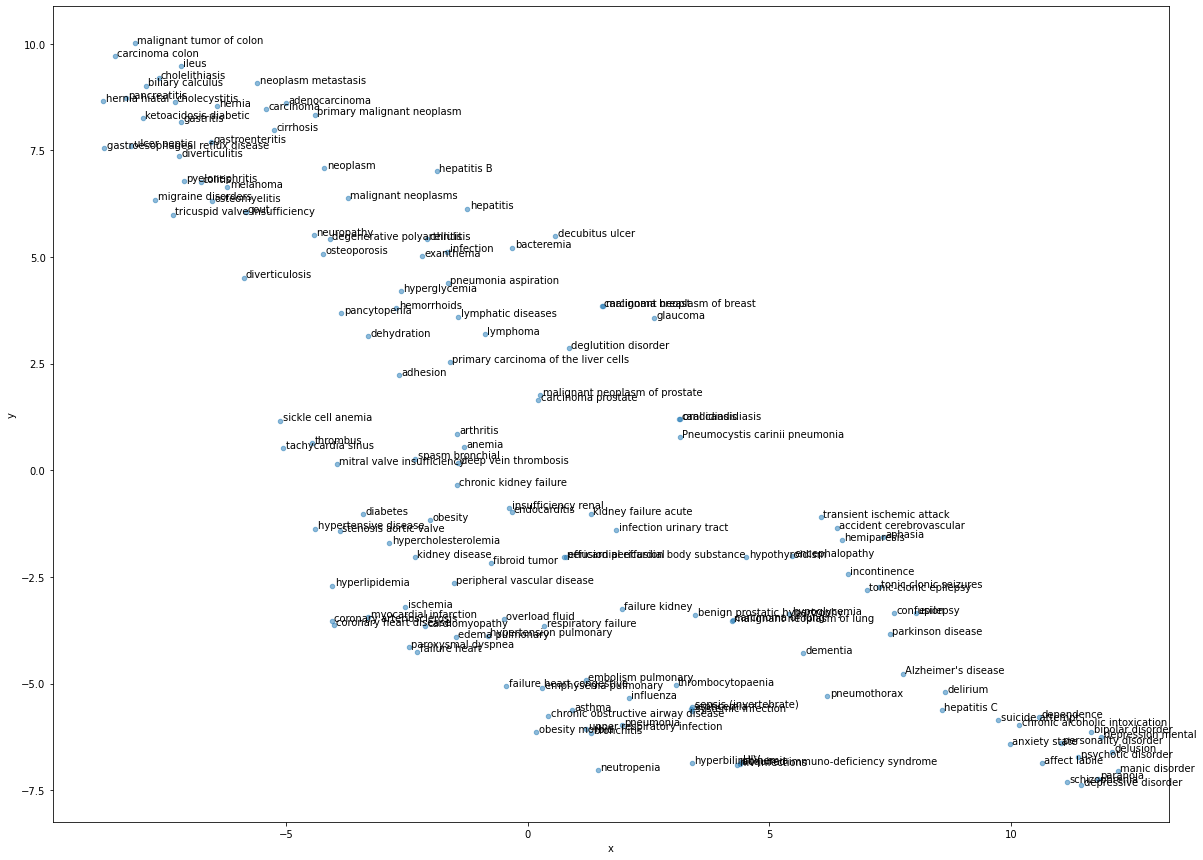

In [45]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
df = pd.DataFrame(list(zip(category, x_coords, y_coords)), columns=['label','x','y'] )
ax = df.plot.scatter(x='x', y='y', alpha=0.5, figsize=(20,15))
for index, row in df.iterrows():
   ax.annotate(row[0], (row[1]+0.05, row[2]))

In [46]:
G4.drop()